<a href="https://colab.research.google.com/github/ssakarin/lmembers/blob/main/L_members_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# 이거 실행(설치)하고 런타임 재시작 하면 한글 출력 가능
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [1]:
import pandas as pd
pd.DataFrame([3,4,5,6,7,8])

,0
0,3
1,4
2,5
3,6
4,7
5,8


In [ ]:
import pandas as pd
pd.DataFrame([1,2,3,4,5,6])

,0
0,1
1,2
2,3
3,4
4,5
5,6


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from keras import layers
from keras import Sequential
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Embedding

from keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px

# 한글 폰트 출력
plt.rc('font', family='NanumBarunGothic') 
# warning 무시
warnings.filterwarnings(action='ignore')

In [ ]:
# 버블 차트 그림그리용

#랜덤 버블 그래프용 함수
import random
import matplotlib

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels ):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        color : Random RGBA
        """
        for i in range(len(self.bubbles)):
            red = random.randint(1,128) + 127
            green = random.randint(1,128) + 127
            blue = random.randint(1,128) + 127
            RGBA = '#%02x%02x%02x' % (red, green, blue)
            #RGBA = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
            circ = plt.Circle(    
                self.bubbles[i, :2], self.bubbles[i, 2], color = RGBA)
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/sample/lmemdata/'

In [ ]:
purchase_tr_path = '구매상품TR.txt'
merchant_cl_path = '상품분류.txt'
compet_use_path = '경쟁사이용.txt'
cust_demo_path = '고객DEMO.txt'
channel_use_path = '채널이용.txt'
membership_path = '멤버십여부.txt'

# 파일 불러오기

In [ ]:
df_membership = pd.read_csv(path+membership_path, encoding='cp949')   # 멤버쉽이 있는 회원은 기입됨
df_channel_use = pd.read_csv(path+channel_use_path, encoding='cp949') # 멤버들이 어떤 채널로 사용하는지
df_cust_demo = pd.read_csv(path+cust_demo_path, encoding='cp949') # 멤버들의 기본 신상 정보
df_compet_use = pd.read_csv(path+compet_use_path, encoding='cp949') # 멤버들이 경쟁 회사를 사용하는지
df_merchant_cl = pd.read_csv(path+merchant_cl_path, encoding='cp949') # 상품 정보

In [ ]:
# 대용량 데이터 불러오기 (transaction은 용량이 겁나 큼)
df_purchase_tr = pd.read_csv(path+purchase_tr_path, encoding='cp949', chunksize = 1000000) #100만개 단위로 끊기, 실제 transaction 데이터
chunk = list(df_purchase_tr)

print(len(chunk)) # 몇개 chunk인지 출력

df_purchase_tr = pd.concat(chunk)  # 데이터 넣기
df_purchase_tr.shape

29


(28593030, 10)

# 멤버 정보 합치기 

- 고객번호, 성별, 연령대, 거주지역, 멤버십유무, 멤버십가입년월, 경쟁사, 경쟁사 이용연월, 제휴사(모바일/온라인), 최근3개월간 이용횟수


In [ ]:
print(df_cust_demo.columns)
print(df_membership.columns)
print(df_compet_use.columns)
print(df_channel_use.columns)
#np.unique(pd.DataFrame(df_compet_use.groupby('고객번호')['경쟁사'].count())['경쟁사'], return_counts = True)
#df_channel_use.제휴사.value_counts()

Index(['고객번호', '성별', '연령대', '거주지역'], dtype='object')
Index(['고객번호', '멤버십명', '가입년월'], dtype='object')
Index(['고객번호', '제휴사', '경쟁사', '이용년월'], dtype='object')
Index(['고객번호', '제휴사', '이용횟수'], dtype='object')


1. cust_demo  '고객DEMO.txt'



*   항목 추가



- 19383 명의 데이터
- '고객번호', '성별', '연령대', '거주지역' 정보를 담고 있음
- 고객번호, 성별, 연령대는 null값이 없음, 거주지역은 178개 null값 존재

2. compet_use  '경쟁사이용.txt'

- A, B, C, D 4개의 제휴사에 대해서 각각 A1,A2 이런식으로 경쟁사가 존재(A -> B1 이런경우 없음)
- 경쟁사는 총 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02' 9개 존재
- 5881명 / 19383 명의 고객이 경쟁사 이용한 적이 있음
- 응답한 사람들은 경쟁사 이용횟수가 1회~40회 사이로 응답

횟수 :
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 40]


인원 :
[1749,  979,  611,  487,  371,  296,  222,  185,  145,  119,  106,
          87,   97,   61,   69,   47,   43,   36,   28,   25,   16,   17,
          20,   13,   10,    4,    7,    6,   10,    7,    2,    2,    3,
           1]


3. channel_use  '채널이용.txt'

- 4개 계열사 관련 모바일/app(A.MOBILE/APP, B.MOBILE/APP, C.MOBILE/APP, D.MOBILE/APP)
- 2개 계열사 관련 온라인 쇼핑몰(B.ONLINEMALL, C.ONLINEMALL)
- 최근 3개월간 모바일/APP 로그인 횟수 , 최근 3개월간 온라인 쇼핑몰  구매 횟수

- 6766명/19383 이 모바일/온라인을 이용한 적이 있음

- B_MOBILE/APP    5170, A_MOBILE/APP    1435, C_MOBILE/APP      46, D_MOBILE/APP     227
- B_ONLINEMALL    1328, C_ONLINEMALL     618, 


4. membership  '멤버십여부.txt'

- 하이마트, 다둥이, 더원, 롭스 멤버십 중에 하나 가입한 경우 표시
- 멤버십 가입 연월일 표시
- 하이마트    4418 ,다둥이     2009, 더영       642, 롭스       387
- 멤버쉽을 가지고 있는 회원 숫자 6498명/ 19383 (약 1/3 정도)
- 그중 5601이 한개의 멤버십만을 가지고 있음, 837 이 2개, 59명이 3개, 4개 다가지고 있는 사람은 1명

In [ ]:
df_members = pd.merge(df_cust_demo, df_membership, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_compet_use, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_channel_use, on='고객번호', how='outer') 
df_members.rename(columns = {'제휴사_x': '제휴사', '제휴사_y': '사용(모바일/온라인) 채널', '가입연월': '멤버십가입연월', '이용년월':'경쟁사이용년월', '이용횟수':'채널이용횟수' }, inplace = True)
df_members.drop(columns={'제휴사'}, inplace = True)  # 이 컬럼은 지워도 됨. 어짜피 경쟁사 COLUMN에 A,B,C,D중 하나 표시됨
df_members

,고객번호,성별,연령대,거주지역,멤버십명,가입년월,경쟁사,경쟁사이용년월,사용(모바일/온라인) 채널,채널이용횟수
0,1,M,60세이상,60.0,NaN,NaN,A01,201507.0,NaN,NaN
1,1,M,60세이상,60.0,NaN,NaN,A02,201504.0,NaN,NaN
2,1,M,60세이상,60.0,NaN,NaN,B01,201501.0,NaN,NaN
3,1,M,60세이상,60.0,NaN,NaN,B01,201502.0,NaN,NaN
4,1,M,60세이상,60.0,NaN,NaN,B01,201507.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
48842,19379,F,20세~24세,69.0,롭스,201412.0,NaN,NaN,NaN,NaN
48843,19380,F,20세~24세,39.0,롭스,201412.0,NaN,NaN,D_MOBILE/APP,1.0
48844,19381,F,40세~44세,460.0,다둥이,201506.0,NaN,NaN,B_MOBILE/APP,5.0
48845,19382,F,45세~49세,460.0,NaN,NaN,NaN,NaN,B_MOBILE/APP,9.0


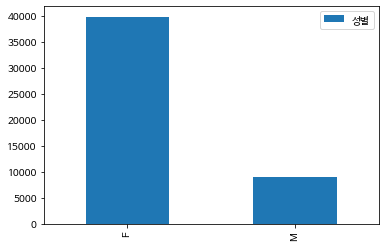

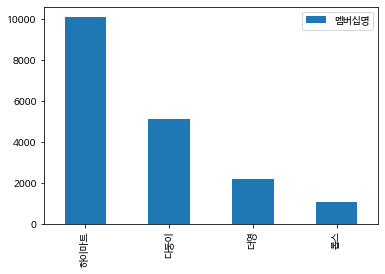

In [ ]:
# 간단히 분포 그려보기
pd.DataFrame(df_members.성별.value_counts()).plot(kind = 'bar'); # 여성이 많음
# pd.DataFrame(df_members.연령대.value_counts()).plot(kind = 'bar'); # 연령 분포
# pd.DataFrame(df_members.거주지역.value_counts()).plot(kind = 'bar');  # 지역코드가 숫자로 나옴
pd.DataFrame(df_members.멤버십명	.value_counts()).plot(kind = 'bar'); # 멤버십은 4종류 (하이마트, 더영, 다동이, 롭스)
#pd.DataFrame(df_members.사용채널.value_counts()).plot(kind = 'bar'); 

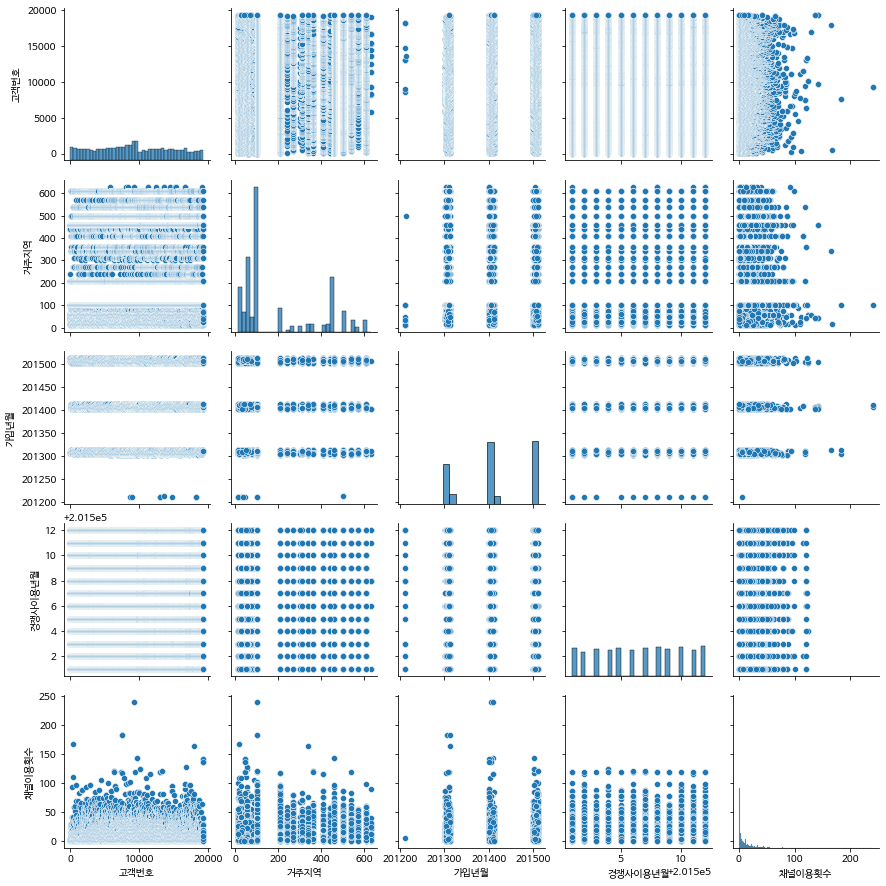

In [ ]:
#sns.jointplot(x= df_members.고객번호, y = df_members.채널이용횟수);
sns.pairplot(df_members);  # 데이터간 관계 그려보기

# 상품 분류 살펴보기

In [ ]:
print(df_merchant_cl.columns)

Index(['제휴사', '대분류코드', '중분류코드', '소분류코드', '중분류명', '소분류명'], dtype='object')


In [ ]:
df_merchant_cl.drop(columns={'대분류코드'},inplace = True)  # 중분류 코드안에 대분류코드가 실제로 들어잇음 예: 대분류 1 -> 중분류 101 / 따라서 대분류코드 drop해도 괜찮음
df_merchant_cl

,제휴사,중분류코드,소분류코드,중분류명,소분류명
0,A,101,A010101,일용잡화,위생세제
1,A,101,A010102,일용잡화,휴지류
2,A,101,A010103,일용잡화,뷰티상품
3,A,101,A010104,일용잡화,일용잡화
4,A,101,A010105,일용잡화,세트상품
...,...,...,...,...,...
4381,D,802,D080204,아이메이크업,아이섀도우
4382,D,802,D080205,아이메이크업,메이크업세트
4383,D,803,D080301,립메이크업,립스틱/립라이너
4384,D,803,D080302,립메이크업,립글로즈/틴트


In [ ]:
# 제휴사는 4종류, 서로 분류가 완전히 다름
cat_a_df = df_merchant_cl[df_merchant_cl.제휴사 == 'A'] 
cat_b_df = df_merchant_cl[df_merchant_cl.제휴사 == 'B'] 
cat_c_df = df_merchant_cl[df_merchant_cl.제휴사 == 'C'] 
cat_d_df = df_merchant_cl[df_merchant_cl.제휴사 == 'D'] 

print('A 제휴사의 중분류: ',cat_a_df.중분류명.unique())  # 백화점?
print('\n')
print('B 제휴사의 중분류: ',cat_b_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('C 제휴사의 중분류: ',cat_c_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('D 제휴사의 중분류: ',cat_d_df.중분류명.unique())  # 롭스?

# print(cat_a_df.소분류명.unique())  # 백화점?
# print(cat_b_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_c_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_d_df.소분류명.unique())  # 롭스?

A 제휴사의 중분류:  ['일용잡화' '육류' '축산가공' '농산물' '수산품' '가공식품' '젓갈/반찬' '건강식품' '주류' '차/커피' '기타'
 '섬유잡화' '액세서리' '화장품' '보석' '준보석/시계' '피혁잡화' '구두' '아동' '캐주얼' '커리어' '트래디셔널'
 '시티웨어' '란제리/내의' '블라우스' '기타의류' '디자이너' '모피/피혁' '남성정장' '남성캐주얼' '교복' '셔츠'
 '남성 트랜디' '스포츠' '골프용품' '대형가전' '소형가전' '통신/컴퓨터' '악기' '전자/전기' '주방가전' '명품'
 '주방용품' '문구/팬시' '생활잡화' '식기' '가구' '침구/수예' '웨딩']


B 제휴사의 중분류:  ['열매채소' '버섯' '온라인버섯/열매채소' '조리반찬' '시즌반찬' '포장젓갈' '포장반찬' '양곡' '잡곡류' '즉석도정미'
 '가공양곡' '잎채소' '뿌리채소' '버섯류' '샐러드채소' '약초' '양념류' '식자재' '친환경채소' '김치채소'
 '온라인잎/샐러드채소' 'LOCAL잎채소' 'LOCAL김치채소' '샐러드/간편채소' '대중선어' '냉동수산물' '생선선물세트'
 '고등어/삼치' '대구' '도미/민어' '기타구색생선' '꽁치/가자미' '오징어' '조기/명태' '국산게/갈치' '선물세트'
 '즉석구이안주' '마른안주' '멸치건명태' '해조류' '특산물' '건오징어' '조미오징어' '육포' '쥐치포' '마른안주선물세트'
 'Fast Food' '편의시설' '레스토랑' '카페' '판매시설' '주유소' '브랜드조리' '베이커리' '구이' '튀김' '밥류'
 '구이찜조리' '반찬류' '대용식' '이벤트조리' '간식조리' '간편조리' '튀김조리' '피자' '냉장음료' '데일리처분'
 '흰우유' '가공우유' '요구르트' '유제품' '브랜드빵' '치즈' '디저트' '유가공' '조미료' '소스류' '장류' '식용유지'
 '조미선물세트' '가루' '향신료' '액상조미료' '복합조미료' '소금/설탕류' '수입조미' '간편조리식품' '

In [ ]:
np.unique(df_purchase_tr.제휴사, return_counts = True)  # 제휴사별 구매 횟수

(array(['A', 'B', 'C', 'D'], dtype=object),
 array([ 5770318, 13338074,  9379236,   105402]))

# 상품 Transaction EDA

## 전체 데이터 분포 살펴보기


In [ ]:
print(df_purchase_tr.columns)

Index(['제휴사', '영수증번호', '대분류코드', '중분류코드', '소분류코드', '고객번호', '점포코드', '구매일자',
       '구매시간', '구매금액'],
      dtype='object')


In [ ]:
df_purchase_tr.drop(columns = {'영수증번호', '대분류코드'}, inplace = True) # 없어도 되는 column 제거, 영수증번호도 정말 없어도 되는지 확인은 안해봤는데 아마... 없어도 될듯
df_purchase_tr.head(5)

,제휴사,중분류코드,소분류코드,고객번호,점포코드,구매일자,구매시간,구매금액
0,B,1504,B150401,17218,44,20140222,20,2420
1,B,1601,B160101,17218,44,20140222,20,1070
2,B,1602,B160201,17218,44,20140222,20,8060
3,B,1803,B180301,17218,44,20140222,20,6000
4,B,509,B050901,17674,44,20140222,22,1120


In [ ]:
df_purchase_tr['구매일자'] = pd.to_datetime(df_purchase_tr['구매일자'],format='%Y%m%d')

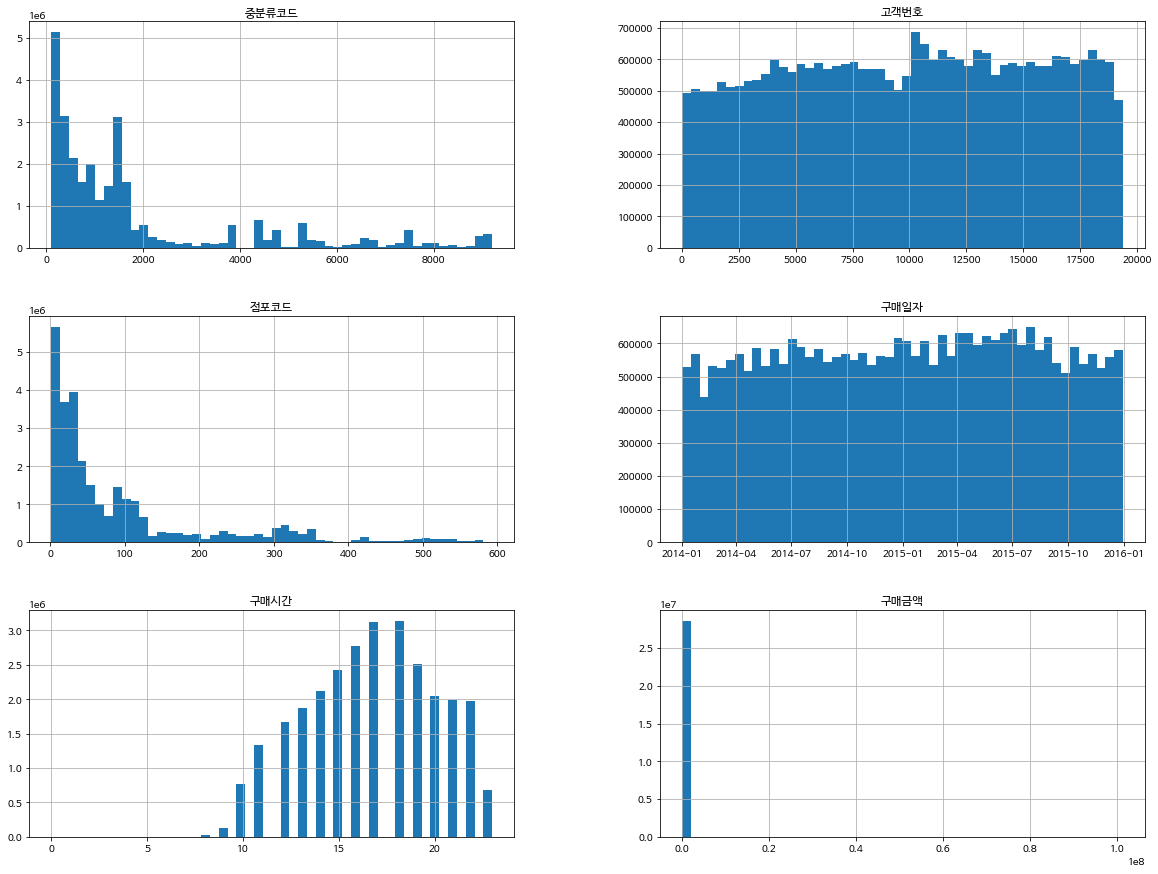

In [ ]:
df_purchase_tr.hist(bins=50, figsize=(20, 15));  # 데이터 분포 살펴보기
#구매금액이 1원부터 1억원까지 다양
#np.log(df_purchase_tr.구매금액).hist(); 

## 전체 시계열 구매금액(day, month, quarter, year)

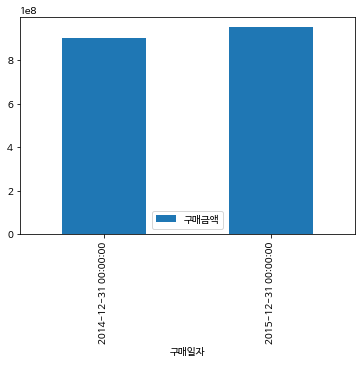

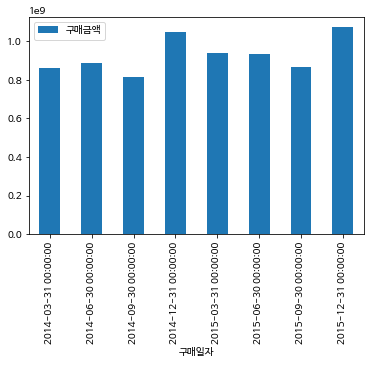

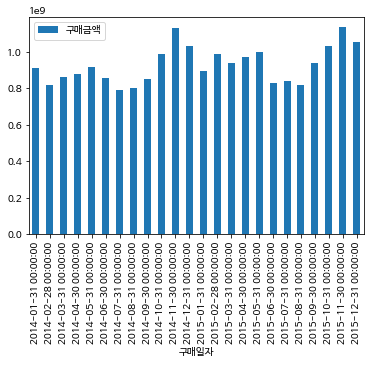

In [ ]:
# 날짜별 구매금액
sum_purchased = pd.DataFrame(df_purchase_tr.groupby('구매일자').구매금액.sum())

# 연도, 분기, 월별 구매금액
sum_purchased.resample('Y').mean().plot(kind = 'bar');
sum_purchased.resample('Q').mean().plot(kind = 'bar');
sum_purchased.resample('M').mean().plot(kind = 'bar');

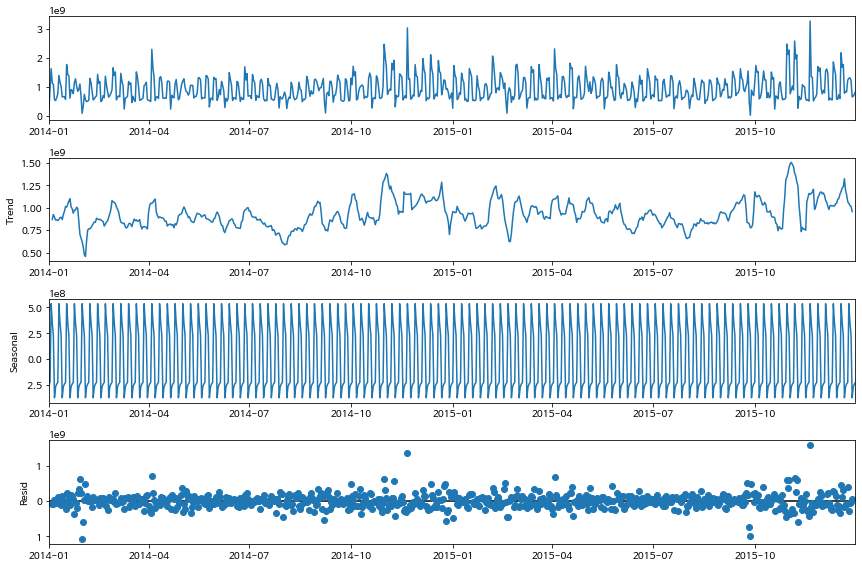

In [ ]:
# 구매금액 계절성(seasonality)
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sum_purchased, model='additive')
plt.rcParams['figure.figsize'] = [12, 8]
fig = result.plot()
plt.show()

- 전체 기준으로는 두드러지는 계절성은 없음
- 항목별로는 계절성이 존재할 듯?

## 고객별 시계열 구매금액 (연도별)


In [ ]:
# 고객별 구매금액
user_df = pd.DataFrame(df_purchase_tr.groupby(['고객번호','구매일자']).구매금액.sum())
user_df = user_df.swaplevel(0, 1, axis = 0)
user_df = user_df.unstack().resample('Y').sum()   # 개별 고객의 월별 구매금액 합계
user_df = user_df['구매금액']   # column: 고객번호, row: 구매 월

# 1번 10번까지 고객의 쿼터별별 구매금액 합계 그래프
# 한번 그려보기
# 실제로는 전체 고객들 구매 동향 비율로 나누어줘야 할듯
# 이걸 연간/분기/월간 어떤걸로 나누어야 할지...
# plt.figure(figsize = (15,10))
# for i in range (10) :
#   plt.plot(user_df[i+1]);

In [ ]:
user_df.loc['2014/2015 매출비율'] = user_df.loc['2014-12-31']/user_df.loc['2015-12-31']

In [ ]:
# 2015년에 구매금액이 2014년 비교해서 감소한 고객 비율
(user_df.loc['2014/2015 매출비율'] > 1).sum() / 19383

0.44533869885982563

2014년 대비 2015년 매출액은 증가했지만 44.5%의 고객은 2015년에 물건을 더 사지 않음

## 제휴사별 매출액 및 중분류별 매출액 

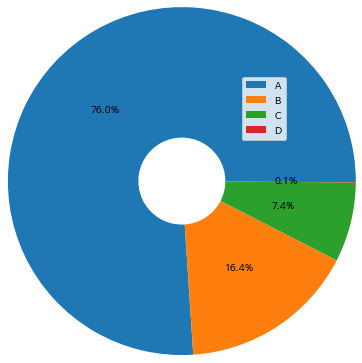

In [ ]:
# A, B, C, D 제휴사의 매출 비중

branch_df = pd.DataFrame(df_purchase_tr.groupby(['제휴사']).구매금액.sum())
branch_df = branch_df/branch_df.sum()

plt.pie(branch_df, autopct='%.1f%%',labeldistance = 0.8, wedgeprops=dict(width=1.5), radius = 2);
plt.legend(branch_df.index, loc='best');

- 대부분이 A 제휴사의 매출, B, C, D 순서

In [ ]:
# 제휴사별, 중분류 코드에 따른 구매금액
jehyu_df = pd.DataFrame(df_purchase_tr.groupby(['제휴사','중분류코드']).구매금액.sum())

Text(0.5, 1.0, 'A사 중분류 구매금액 비율')

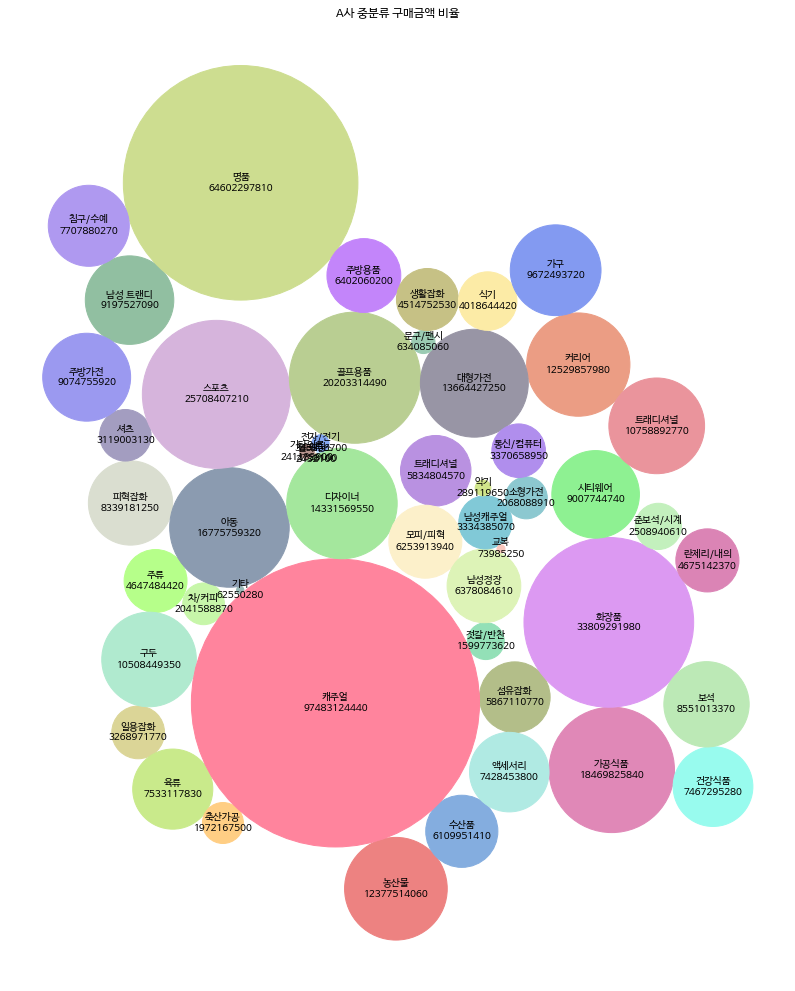

In [ ]:
# A 제휴사의 중분류별 항목 매출 비율
A_revenue_df = jehyu_df.loc['A']
A_revenue_df = pd.merge(A_revenue_df, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= A_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, A_revenue_df.중분류명+'\n'+A_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('A사 중분류 구매금액 비율')

Text(0.5, 1.0, 'B사 중분류 구매금액 비율')

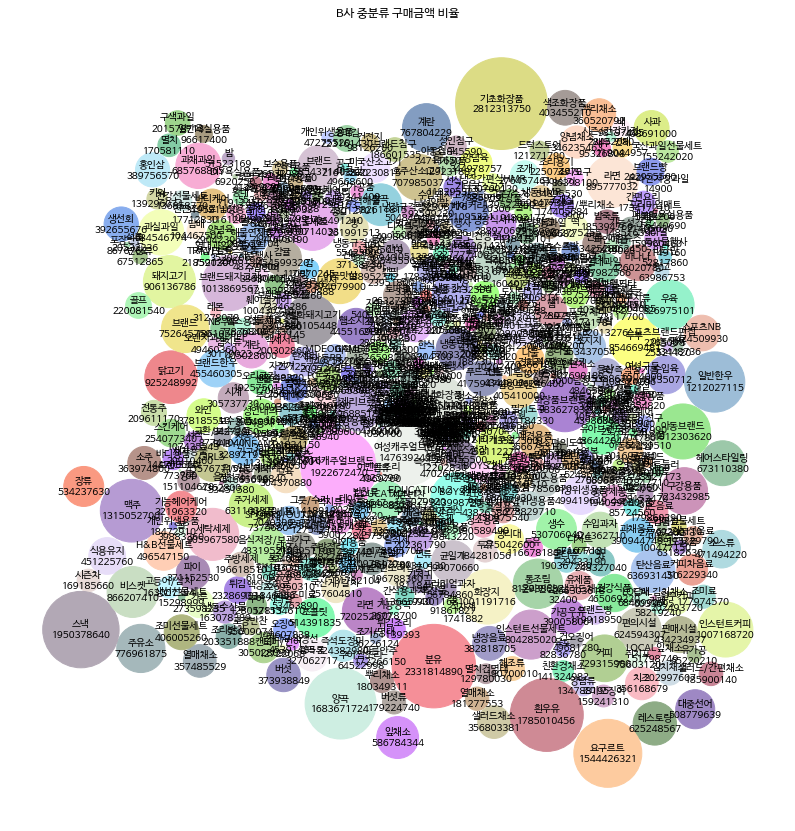

In [ ]:
# B 제휴사의 중분류별 항목 매출 비율
B_revenue_df = jehyu_df.loc['B']
B_revenue_df = pd.merge(B_revenue_df, cat_b_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= B_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, B_revenue_df.중분류명+'\n'+B_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('B사 중분류 구매금액 비율')

Text(0.5, 1.0, 'C사 중분류 구매금액 비율')

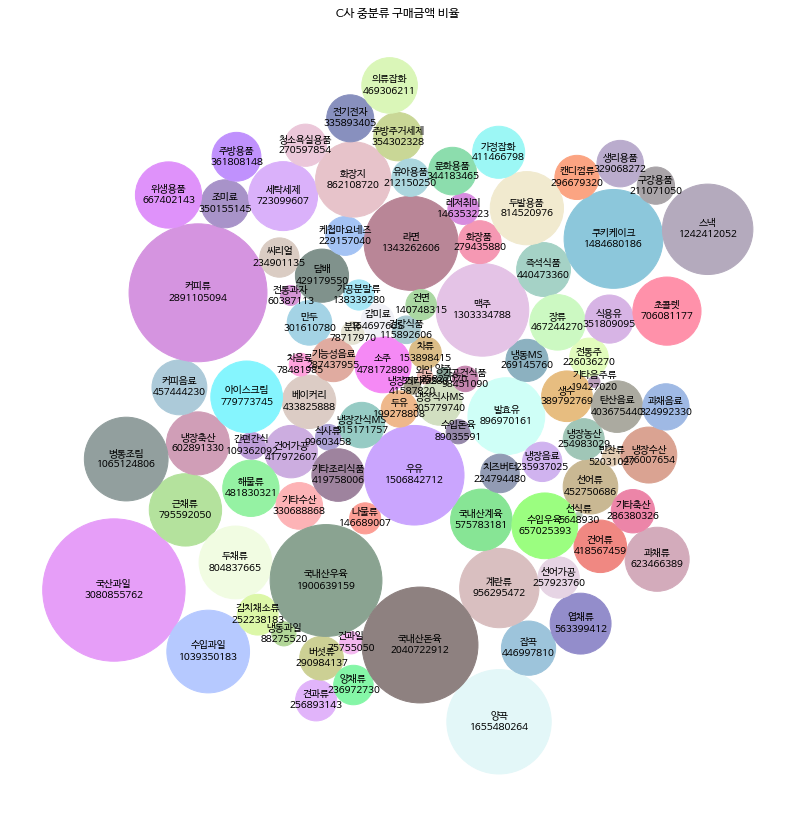

In [ ]:
# C 제휴사의 중분류별 항목 매출 비율
C_revenue_df = jehyu_df.loc['C']
C_revenue_df = pd.merge(C_revenue_df, cat_c_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= C_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, C_revenue_df.중분류명+'\n'+C_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('C사 중분류 구매금액 비율')

Text(0.5, 1.0, 'D사 중분류 구매금액 비율')

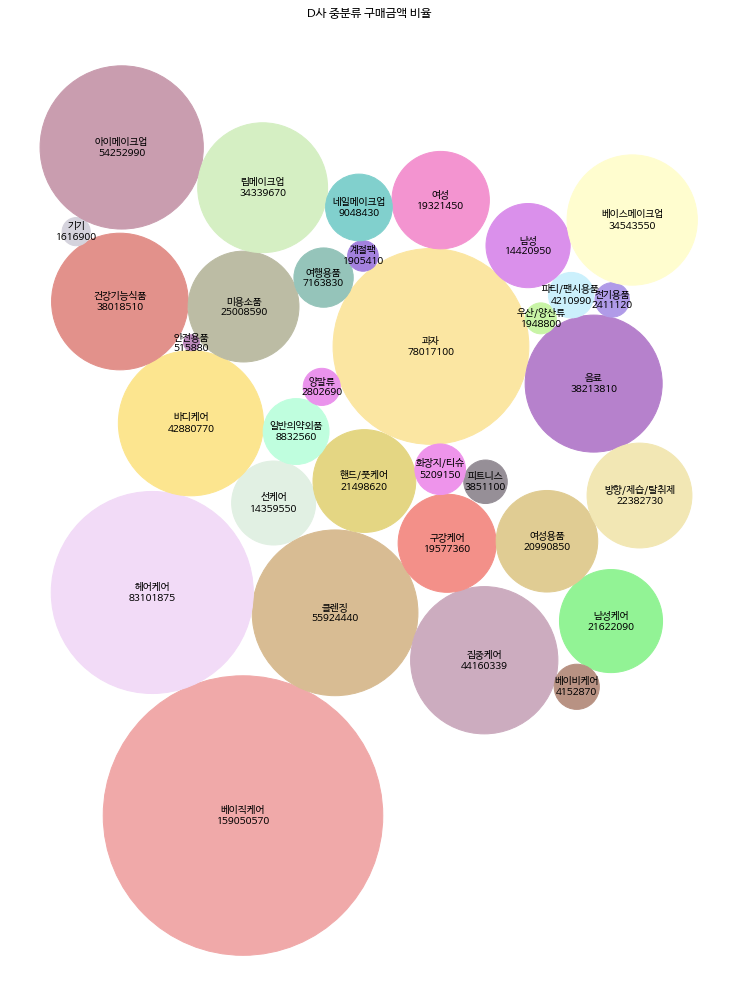

In [ ]:
# D 제휴사의 중분류별 항목 매출 비율
D_revenue_df = jehyu_df.loc['D']
D_revenue_df = pd.merge(D_revenue_df, cat_d_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= D_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, D_revenue_df.중분류명+'\n'+D_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('D사 중분류 구매금액 비율')

## 시간대별 매출액 

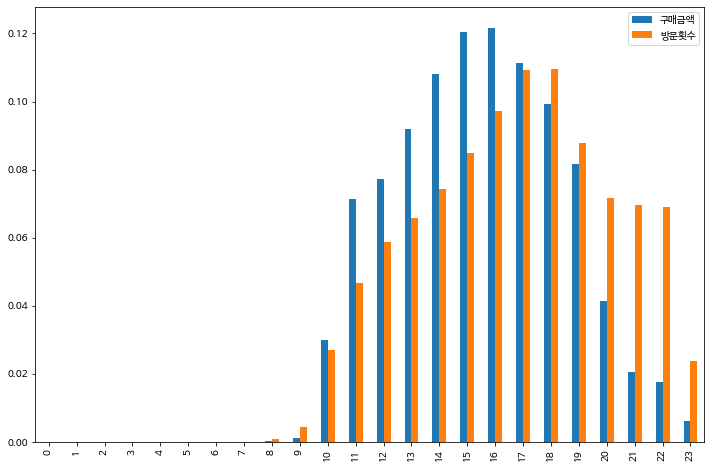

In [ ]:
#시간별 구매금액, 시간별 방문인원
visit_count_df = pd.DataFrame(df_purchase_tr['구매시간'].value_counts())
visit_count_df.rename(columns = {'구매시간':'방문횟수'},inplace = True)

purchase_time_df = pd.DataFrame(df_purchase_tr.groupby(['구매시간']).구매금액.sum())
purchase_time_df = pd.concat((purchase_time_df, visit_count_df), axis = 1)
purchase_time_df = (purchase_time_df/purchase_time_df.sum())
purchase_time_df.plot(kind = 'bar',figsize=(12,8));

- 특이할 만한 사항: 20시 이후 방문 고객은 방문횟수는 많으나 구매금액은 낮음
- 마감세일? 밤늦게 오는 사람들은 저가(생필품) 위주 구매인가?

## 성별  거주지역별 연령대별 매출액 
- 1인당 평균 매출액, 합계 매출액, 인원 순으로 추출

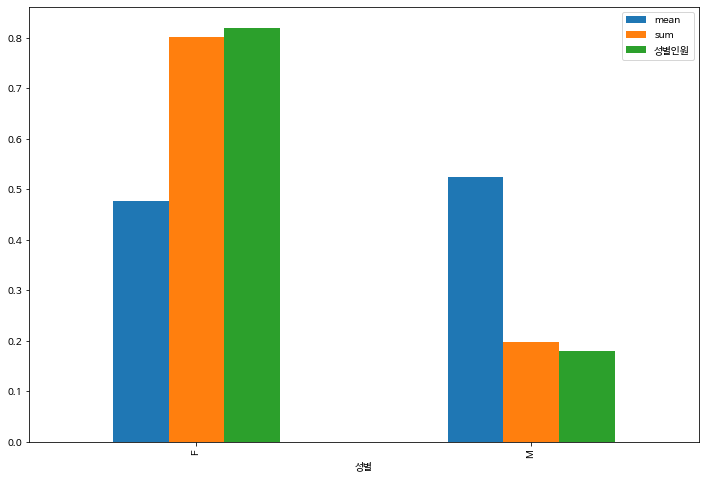

In [ ]:
# 성별 1인당 매출액, 합계매출액, 인원
gender = df_members[['고객번호','성별']].drop_duplicates(subset=['고객번호'])
gender_hist = pd.DataFrame(gender.성별.value_counts())
gender_hist.reset_index(inplace = True)

gender_hist.rename(columns = {'index': '성별', '성별':'성별인원'},inplace = True)

gender = pd.merge(gender,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
gender = gender.groupby('성별').구매금액.agg(['mean','sum'])
gender = pd.merge( gender,gender_hist, on='성별', how='left')
gender.set_index('성별',inplace = True)


# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
gender = (gender/gender.sum())
gender.plot(kind = 'bar',figsize=(12,8));

* 의외로 남자가 1인당 구매금액이 더 많음
* 근데 이게 진짜 남자인가 아니면 카드(멤버십) 명의만 남자인가?

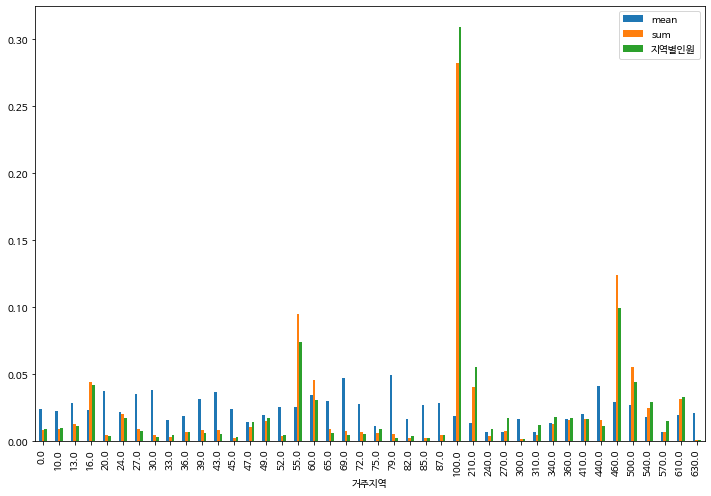

In [ ]:
# 거주지역별 1인당 매출액, 합계매출액, 인원

location = df_members[['고객번호','거주지역']].drop_duplicates(subset=['고객번호'])
location = location.fillna(0)  # 거주지역이 null인 인원이 일부 있음 (178명)지역을 0로 셋팅
location_hist = pd.DataFrame(location.거주지역.value_counts())
location_hist.reset_index(inplace = True)
location_hist.rename(columns = {'index': '거주지역', '거주지역':'지역별인원'},inplace = True)
location = pd.merge( location,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
location = location.groupby('거주지역').구매금액.agg(['mean','sum'])
location = pd.merge( location,location_hist, on='거주지역', how='left')
location.set_index('거주지역',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
location = (location/location.sum())
location.plot(kind = 'bar',figsize=(12,8));

- 매출액은 압도적으로 100번지역이 많지만, 1인당 매출액은 그렇지 않음
- 1인당 매출액은 지역별로 나름 균등한 편임

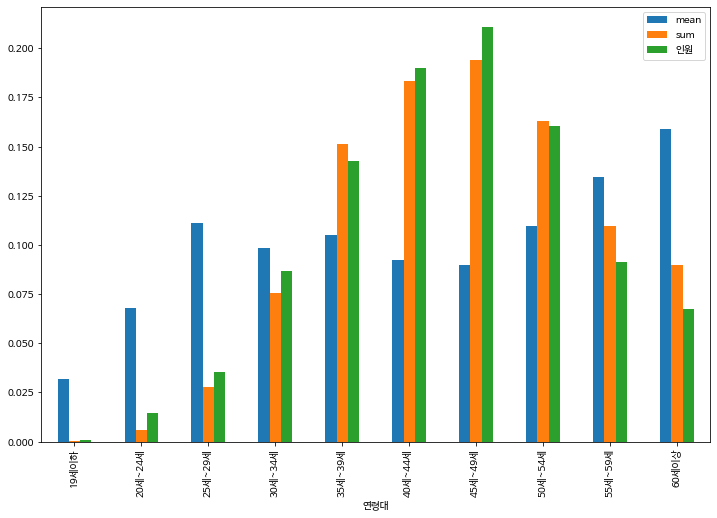

In [ ]:
# 연령별 1인당 매출액, 합계매출액, 인원

age = df_members[['고객번호','연령대']].drop_duplicates(subset=['고객번호'])
age = age.fillna(0)  # null값 존재시 채우기
age_hist = pd.DataFrame(age.연령대.value_counts())
age_hist.reset_index(inplace = True)
age_hist.rename(columns = {'index': '연령대', '연령대':'인원'},inplace = True)
age = pd.merge( age,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
age = age.groupby('연령대').구매금액.agg(['mean','sum'])
age = pd.merge( age,age_hist, on='연령대', how='left')
age.set_index('연령대',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
age = (age/age.sum())
age.plot(kind = 'bar',figsize=(12,8));

객단가는 60대, 50대 20대 순이고
매출액은 40대 50대 30대가 많음
인원은 45~49세를 peak를 찍고 있음

## 멤버십 종류(유무), 채널 종류(online,mobile), 경쟁사 이용 종류(유무)에 따른 매출액

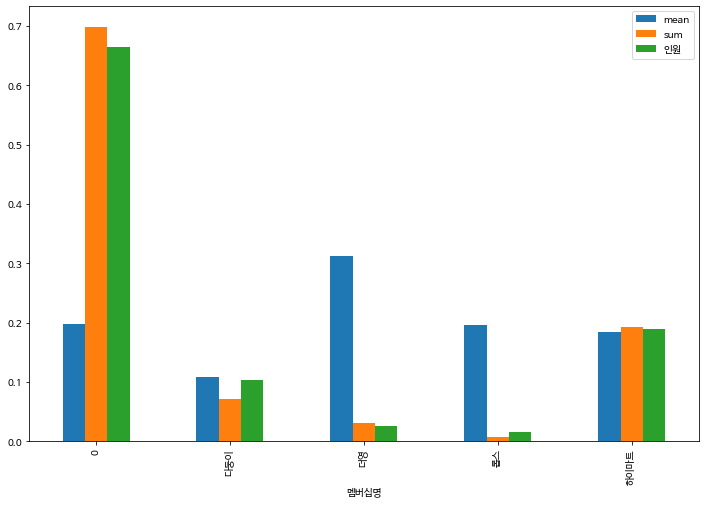

In [ ]:
# 멤버십 종류(유무)에 따른 1인당 매출액, 합계매출액, 인원

membership = df_members[['고객번호','멤버십명']].drop_duplicates(subset=['고객번호'])
membership = membership.fillna(0)  # null값 존재시 채우기
membership_hist = pd.DataFrame(membership.멤버십명.value_counts())
membership_hist.reset_index(inplace = True)
membership_hist.rename(columns = {'index': '멤버십명', '멤버십명':'인원'},inplace = True)
membership = pd.merge( membership,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
membership = membership.groupby('멤버십명').구매금액.agg(['mean','sum'])
membership = pd.merge( membership,membership_hist, on='멤버십명', how='left')
membership.set_index('멤버십명',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
membership = (membership/membership.sum())
membership.plot(kind = 'bar',figsize=(12,8));

* 매출액 자체는 멤버십이 없는 사람, 하이마트 순서임
* 멤버십에 의한 lock-in이 크게 강한건지?는 잘 모르겠음.
* 그러나 객단가는 더영, 롭스 멤버십은 확실히 객단가가 높아지는 모습




  사용(모바일/온라인) 채널     인원
0              0  12617
1   B_MOBILE/APP   4688
2   A_MOBILE/APP   1435
3   C_ONLINEMALL    415
4   D_MOBILE/APP    169
5   C_MOBILE/APP     32
6   B_ONLINEMALL     27


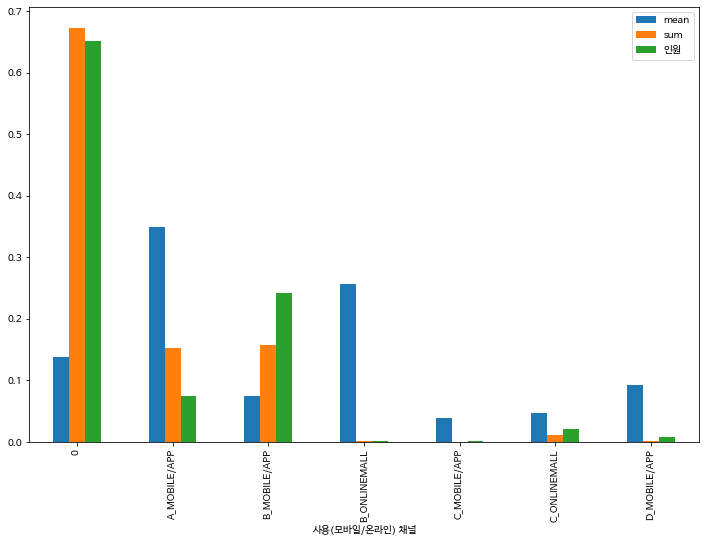

In [ ]:
# 채널 종류(online,mobile)(유무)에 따른 1인당 매출액, 합계매출액, 인원

channel = df_members[['고객번호','사용(모바일/온라인) 채널']].drop_duplicates(subset=['고객번호'])
channel = channel.fillna(0)  # null값 존재시 채우기
channel_hist = pd.DataFrame(channel['사용(모바일/온라인) 채널'].value_counts())
channel_hist.reset_index(inplace = True)
channel_hist.rename(columns = {'index': '사용(모바일/온라인) 채널', '사용(모바일/온라인) 채널':'인원'},inplace = True)
channel = pd.merge( channel,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
channel = channel.groupby('사용(모바일/온라인) 채널').구매금액.agg(['mean','sum'])
channel = pd.merge( channel,channel_hist, on='사용(모바일/온라인) 채널', how='left')
channel.set_index('사용(모바일/온라인) 채널',inplace = True)
print(channel_hist)
# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
channel = (channel/channel.sum())
channel.plot(kind = 'bar',figsize=(12,8));

- 아마 B가 롯데마트일것인데 B online mall의 객단가가 매우 높음
- 대량으로 주문하는 업체/자영업자일 확률이 높지 않을까?
- 전반적으로 온라인/모바일 이용 고객들이 객단가가 높음
- 적극적으로 온라인/모바일 채널 홍보,가입 유도가 필요?

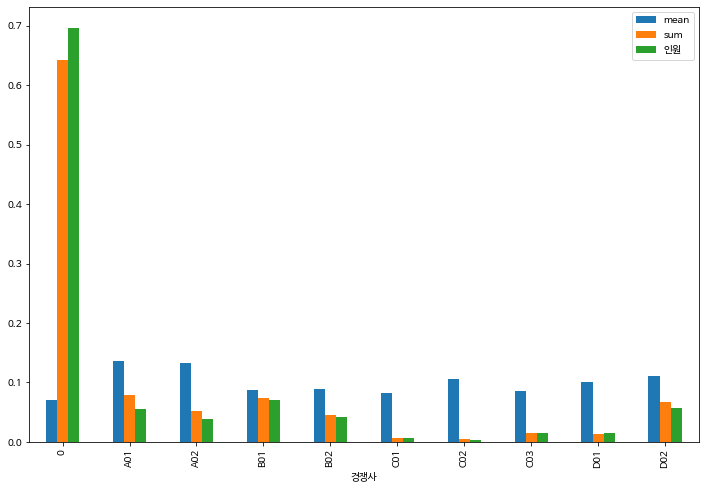

In [ ]:
# 경쟁사 이용 종류(유무)에 따른 1인당 매출액, 합계매출액, 인원

compet = df_members[['고객번호','경쟁사']].drop_duplicates(subset=['고객번호'])
compet = compet.fillna(0)  # null값 존재시 채우기
compet_hist = pd.DataFrame(compet['경쟁사'].value_counts())
compet_hist.reset_index(inplace = True)
compet_hist.rename(columns = {'index': '경쟁사', '경쟁사':'인원'},inplace = True)
compet = pd.merge( compet,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
compet = compet.groupby('경쟁사').구매금액.agg(['mean','sum'])
compet = pd.merge( compet,compet_hist, on='경쟁사', how='left')
compet.set_index('경쟁사',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
compet = (compet/compet.sum())
compet.plot(kind = 'bar',figsize=(12,8));

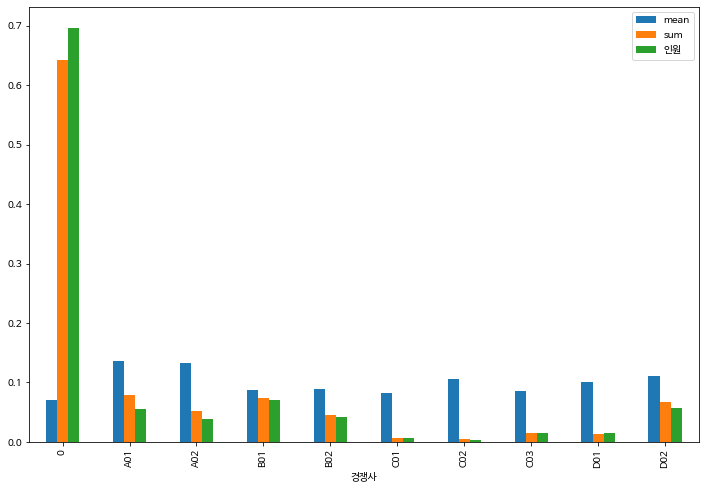

In [ ]:
# 경쟁사 이용 종류(유무)에 따른 1인당 매출액, 합계매출액, 인원

compet = df_members[['고객번호','경쟁사']].drop_duplicates(subset=['고객번호'])
compet = compet.fillna(0)  # null값 존재시 채우기
compet_hist = pd.DataFrame(compet['경쟁사'].value_counts())
compet_hist.reset_index(inplace = True)
compet_hist.rename(columns = {'index': '경쟁사', '경쟁사':'인원'},inplace = True)
compet = pd.merge( compet,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
compet = compet.groupby('경쟁사').구매금액.agg(['mean','sum'])
compet = pd.merge( compet,compet_hist, on='경쟁사', how='left')
compet.set_index('경쟁사',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
compet = (compet/compet.sum())
compet.plot(kind = 'bar',figsize=(12,8));

- 이거는 어떻게 분석이 되는지 분석이 필요함

# 기타 필요한거

In [ ]:
# # 극좌표 그래프

# purchase_time_df['theta']= purchase_time_df.index*360/len(purchase_time_df)
# purchase_time_df['구매금액'] = purchase_time_df['구매금액']/purchase_time_df['구매금액'].max()
# fig = px.line_polar(purchase_time_df, r = '구매금액', theta = 'theta', line_close = True, color_discrete_sequence=px.colors.sequential.Plasma_r,template="plotly_dark", render_mode = 'svg')
# fig.update_layout(
#     polar = dict(
#         radialaxis = dict(autorange = False, showticklabels=False, ticks=''),
#         #angularaxis = dict(showticklabels=False, ticks='')
#     )
# )
# fig.show();


# treemap #  연도별 제휴사별 등 보여주기 좋은 그래프

# fig = px.treemap(total, path=['시기','국적'], values = '방문객수')
# fig.show() 